## Object

* Booking probability model: estimate probability of vehicles being booked
* Use predicted booking probability as input to build Pricing strategy model

### Import module

In [80]:
import numpy as np 
import math 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns 
sns.set_palette('muted')
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import os 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import timedelta
import pickle as pk
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from pandas.plotting import scatter_matrix
import eli5
from eli5.sklearn import PermutationImportance
### Own module
import Common_Includes as CI
import Feature_Selection as FS
import WOE as woe
import Model_Evaluation as ME
random_seed = 78132

## Load Dataset

In [2]:
def load_data(filename):
    print('Data File Name: {}'.format(filename))
    dataset = pd.read_csv(filename)
    return dataset

In [ ]:
dataframe = load_data(r'dataframe_price_eda.csv')

In [4]:
CI.summarize_dataset(dataframe, 'is_booked')

(1890, 20)
   vehicle_id        date  is_booked    tmv category_grouped  \
0      333483  2018-05-25          0  14569          midsize   
1      304273  2018-05-12          1   4201          compact   
2      298081  2018-04-07          1   5724          midsize   
3      406331  2018-12-31          1  39102              suv   
4      456223  2018-08-09          0   9666          midsize   

   demand_supply_ratio  price year_month  day_of_month  day_of_week  weekend  \
0             1.902318     30    2018-05            25            5        0   
1            14.622831     39    2018-05            12            6        1   
2             8.659708     24    2018-04             7            6        1   
3            13.570390    121    2018-12            31            1        0   
4             1.297453     42    2018-08             9            4        0   

   holiday  category_grouped_num most_recent_booked_date  \
0        0                     1              2018-03-03   
1  

In [5]:
CI.describe_table(dataframe)

,Variable Name,Variable Type,Unique Values,Percentage of Missing Value
0,most_recent_nobooked_date,object,341,10.05%
1,days_past_since_last_booked,float64,190,9.05%
2,most_recent_booked_date,object,366,9.05%
3,index,int64,1890,0.00%
4,weekend,int64,2,0.00%
5,booked_rate_past28days,float64,64,0.00%
6,most_recent_nobooked_price,float64,73,0.00%
7,most_recent_booked_price,float64,66,0.00%
8,category_grouped_num,int64,5,0.00%
9,holiday,int64,2,0.00%


#### Fill the missing value for days_past_since_last_booked
* There are 9.05% of records of days_past_since_last_booked have missing value
* These variable is build as how many days from last booked date to the current data of each vehicle in each day
* Missing value of these variables means for that day, this vehicle didn't booked before the current day based on the data we have 
* The minimum value of this variable is 1 from current data, so we can safe to fill with 0, which indicates this vehicle didn't booked before the current day

In [6]:
dataframe['days_past_since_last_booked'].fillna(0, inplace = True)

In [7]:
dataframe.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price,year_month,day_of_month,day_of_week,weekend,holiday,category_grouped_num,most_recent_booked_date,most_recent_booked_price,most_recent_nobooked_date,most_recent_nobooked_price,days_past_since_last_booked,booked_rate_past28days,average_list_price_past28days
0,333483,2018-05-25,0,14569,midsize,1.902318,30,2018-05,25,5,0,0,1,2018-03-03,24.0,2018-05-20,30.0,83.0,0.000000,30.000000
1,304273,2018-05-12,1,4201,compact,14.622831,39,2018-05,12,6,1,0,0,2018-05-06,41.0,2018-05-09,37.0,6.0,0.666667,38.444444
2,298081,2018-04-07,1,5724,midsize,8.659708,24,2018-04,7,6,1,0,1,2018-04-02,24.0,2018-02-27,24.0,5.0,1.000000,24.000000
3,406331,2018-12-31,1,39102,suv,13.570390,121,2018-12,31,1,0,0,2,2018-12-29,121.0,2018-12-20,85.0,2.0,0.500000,99.375000
4,456223,2018-08-09,0,9666,midsize,1.297453,42,2018-08,9,4,0,0,1,NaN,0.0,2018-08-06,42.0,0.0,0.000000,42.000000


In [8]:
dataframe.columns

Index(['vehicle_id', 'date', 'is_booked', 'tmv', 'category_grouped',
       'demand_supply_ratio', 'price', 'year_month', 'day_of_month',
       'day_of_week', 'weekend', 'holiday', 'category_grouped_num',
       'most_recent_booked_date', 'most_recent_booked_price',
       'most_recent_nobooked_date', 'most_recent_nobooked_price',
       'days_past_since_last_booked', 'booked_rate_past28days',
       'average_list_price_past28days'],
      dtype='object')

## Note:
* Binary Classification Model
* Target: is_booked
* Variables include:
    * 1. tmv
    * 2. demand_supply_ratio
    * 3. day_of_month
    * 4. day_of_week
    * 5. weekend
    * 6. holiday
    * 7. category_grouped_num
    * 8. most_recent_booked_price (derived variable)
    * 9. most_recent_nobooked_price (derived variable)
    * 10. days_past_since_last_booked (derived variable)
    * 11. booked_rate_past28days (derived variable)
    * 12. average_list_price_past28days (derivedd variable)
* Developement Dataset (70% of random sample) as model development dataset
* Test Dataset (The rest 30% of random sample) as model hold out test dataset

In [9]:
dataframe.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price,year_month,day_of_month,day_of_week,weekend,holiday,category_grouped_num,most_recent_booked_date,most_recent_booked_price,most_recent_nobooked_date,most_recent_nobooked_price,days_past_since_last_booked,booked_rate_past28days,average_list_price_past28days
0,333483,2018-05-25,0,14569,midsize,1.902318,30,2018-05,25,5,0,0,1,2018-03-03,24.0,2018-05-20,30.0,83.0,0.000000,30.000000
1,304273,2018-05-12,1,4201,compact,14.622831,39,2018-05,12,6,1,0,0,2018-05-06,41.0,2018-05-09,37.0,6.0,0.666667,38.444444
2,298081,2018-04-07,1,5724,midsize,8.659708,24,2018-04,7,6,1,0,1,2018-04-02,24.0,2018-02-27,24.0,5.0,1.000000,24.000000
3,406331,2018-12-31,1,39102,suv,13.570390,121,2018-12,31,1,0,0,2,2018-12-29,121.0,2018-12-20,85.0,2.0,0.500000,99.375000
4,456223,2018-08-09,0,9666,midsize,1.297453,42,2018-08,9,4,0,0,1,NaN,0.0,2018-08-06,42.0,0.0,0.000000,42.000000


#### Drop useless variable for next model development
The following variable dropped
* most_recent_booked_date
* most_recent_nobooked_date

In [10]:
var_list = ['vehicle_id', 'date', 'tmv', 'category_grouped',
       'demand_supply_ratio', 'price', 'year_month', 'day_of_month',
       'day_of_week', 'weekend', 'holiday', 'category_grouped_num',
       'most_recent_booked_price',
       'most_recent_nobooked_price',
       'days_past_since_last_booked', 'booked_rate_past28days',
       'average_list_price_past28days']

In [11]:
def split_data(data, cols_X, cols_Y, seed = random_seed, size = 0.3):
    df = data.copy()
    df = df.sample(frac = 1, random_state = seed)
    train_X, test_X, train_Y, test_Y = train_test_split(
                                            df.loc[:, cols_X], 
                                            df.loc[:, cols_Y], 
                                            test_size=size,
                                            random_state = seed
                                            )
    train = train_X.merge(pd.DataFrame(train_Y), left_index = True, right_index = True, how = 'inner')
    train['select'] = 'Development'
    test = test_X.merge(pd.DataFrame(test_Y), left_index = True, right_index = True, how = 'inner')
    test['select'] = 'Test'
    df1 = pd.concat([train, test])
    return df1

#### Split dataset into Development dataset (70%) and test (30%) 
* Development dataset will use for the model training and cross validation for hyperparameter tuning
* Test dataset will use for the model performance evaluation

In [12]:
dataframe2 = split_data(dataframe, var_list, 'is_booked')

In [13]:
dataframe2

,vehicle_id,date,tmv,category_grouped,demand_supply_ratio,price,year_month,day_of_month,day_of_week,weekend,holiday,category_grouped_num,most_recent_booked_price,most_recent_nobooked_price,days_past_since_last_booked,booked_rate_past28days,average_list_price_past28days,is_booked,select
494,497131,2018-11-30,3875,compact,8.348333,25,2018-11,30,5,0,0,0,25.0,30.0,16.0,1.000000,25.000000,1,Development
1195,174075,2018-08-26,5669,midsize,12.210682,46,2018-08,26,7,1,0,1,39.0,34.0,3.0,1.000000,39.000000,1,Development
1379,289235,2018-07-06,17755,midsize,1.959080,55,2018-07,6,5,0,0,1,55.0,55.0,12.0,0.285714,55.000000,1,Development
973,456223,2019-02-06,9666,midsize,0.741782,52,2019-02,6,3,0,0,1,42.0,52.0,175.0,0.000000,52.000000,0,Development
1738,300476,2018-04-09,6353,suv,5.295696,27,2018-04,9,1,0,0,2,27.0,29.0,12.0,1.000000,28.000000,0,Development
1426,405192,2018-08-12,18802,suv,1.578546,68,2018-08,12,7,1,0,2,40.0,0.0,5.0,1.000000,46.000000,1,Development
1506,428355,2018-10-07,22008,suv,1.247073,68,2018-10,7,7,1,0,2,68.0,68.0,2.0,0.500000,96.357143,1,Development
244,326416,2018-06-27,12762,suv,5.716138,40,2018-06,27,3,0,0,2,40.0,40.0,1.0,0.750000,40.000000,1,Development
1841,333483,2019-01-15,14569,midsize,0.686286,40,2019-01,15,2,0,0,1,24.0,40.0,318.0,0.000000,40.000000,0,Development
1504,456223,2018-12-20,9666,midsize,0.905712,52,2018-12,20,4,0,0,1,42.0,52.0,127.0,0.000000,52.000000,0,Development


In [14]:
CI.summarize_dataset(dataframe2[dataframe2['select'] == 'Development'], 'is_booked')

(1323, 19)
      vehicle_id        date    tmv category_grouped  demand_supply_ratio  \
494       497131  2018-11-30   3875          compact             8.348333   
1195      174075  2018-08-26   5669          midsize            12.210682   
1379      289235  2018-07-06  17755          midsize             1.959080   
973       456223  2019-02-06   9666          midsize             0.741782   
1738      300476  2018-04-09   6353              suv             5.295696   

      price year_month  day_of_month  day_of_week  weekend  holiday  \
494      25    2018-11            30            5        0        0   
1195     46    2018-08            26            7        1        0   
1379     55    2018-07             6            5        0        0   
973      52    2019-02             6            3        0        0   
1738     27    2018-04             9            1        0        0   

      category_grouped_num  most_recent_booked_price  \
494                      0                 

In [15]:
CI.summarize_dataset(dataframe2[dataframe2['select'] == 'Test'], 'is_booked')

(567, 19)
      vehicle_id        date    tmv category_grouped  demand_supply_ratio  \
1008      405192  2019-01-30  18802              suv             0.691581   
1319      535905  2018-12-27   7857          upscale            14.532471   
69        289235  2018-08-17  17755          midsize             1.538556   
829       405192  2018-06-02  18802              suv             1.671368   
1231      233590  2018-12-06   7484              suv             3.155828   

      price year_month  day_of_month  day_of_week  weekend  holiday  \
1008     50    2019-01            30            3        0        0   
1319     30    2018-12            27            4        0        0   
69       55    2018-08            17            5        0        0   
829      60    2018-06             2            6        1        0   
1231     40    2018-12             6            4        0        0   

      category_grouped_num  most_recent_booked_price  \
1008                     2                  

### For all the Exploratory data analysis and Variable processing, Please refer to the Part1_dataframe Data Science Case Study_EDA notebook

#### Feature Selection using random forest algorithm for development dataset, Select variables from following list of variables

In [16]:
feature_candidates = ['tmv', 'demand_supply_ratio', 'day_of_month',
       'day_of_week', 'weekend', 'holiday', 'category_grouped_num',
       'most_recent_booked_price', 'most_recent_nobooked_price',
        'booked_rate_past28days', 'days_past_since_last_booked',
       'average_list_price_past28days', 'is_booked']

In [17]:
FS.select_rf(dataframe2.loc[dataframe2['select'] == 'Development', feature_candidates], 'is_booked')

(                              col       imp
 0          booked_rate_past28days  0.224552
 1             demand_supply_ratio  0.157697
 2     days_past_since_last_booked  0.140158
 3                             tmv  0.104681
 4        most_recent_booked_price  0.095107
 5      most_recent_nobooked_price  0.080638
 6                    day_of_month  0.068163
 7   average_list_price_past28days  0.063880
 8                     day_of_week  0.036770
 9            category_grouped_num  0.018357
 10                        weekend  0.008512
 11                        holiday  0.001486,
 ['booked_rate_past28days',
  'demand_supply_ratio',
  'days_past_since_last_booked',
  'tmv',
  'most_recent_booked_price',
  'most_recent_nobooked_price',
  'day_of_month',
  'average_list_price_past28days',
  'day_of_week',
  'category_grouped_num',
  'weekend',
  'holiday'])

#### Feature selection result
* Select top 8 features, which has a least 0.05 importance from random forest selection
    * 'booked_rate_past28days',
    * 'demand_supply_ratio',
    * 'days_past_since_last_booked',
    * 'tmv',
    * 'most_recent_booked_price',
    * 'most_recent_nobooked_price',
    * 'day_of_month',
    * 'average_list_price_past28days'

In [20]:
FS.select_xgboost(dataframe2.loc[dataframe2['select'] == 'Development', feature_candidates], 'is_booked')

(                              col       imp
 0          booked_rate_past28days  0.582067
 1     days_past_since_last_booked  0.092912
 2      most_recent_nobooked_price  0.066597
 3             demand_supply_ratio  0.050062
 4            category_grouped_num  0.042610
 5                             tmv  0.040345
 6   average_list_price_past28days  0.040105
 7                    day_of_month  0.033473
 8        most_recent_booked_price  0.029610
 9                         holiday  0.013631
 10                    day_of_week  0.008589
 11                        weekend  0.000000,
 ['booked_rate_past28days',
  'days_past_since_last_booked',
  'most_recent_nobooked_price',
  'demand_supply_ratio',
  'category_grouped_num',
  'tmv',
  'average_list_price_past28days',
  'day_of_month',
  'most_recent_booked_price',
  'holiday',
  'day_of_week',
  'weekend'])

## Model development using Random Forest Algorithm

In [21]:
feature_selected = ['booked_rate_past28days',
  'demand_supply_ratio',
  'days_past_since_last_booked',
  'tmv',
  'most_recent_booked_price',
  'most_recent_nobooked_price',
  'day_of_month',
  'average_list_price_past28days']

In [22]:
train_X = dataframe2.loc[dataframe2['select'] == 'Development', feature_selected]
train_Y = dataframe2.loc[dataframe2['select'] == 'Development', 'is_booked']
test_X = dataframe2.loc[dataframe2['select'] == 'Test', feature_selected]
test_Y = dataframe2.loc[dataframe2['select'] == 'Test', 'is_booked']

In [90]:
def RF_Classifier_GridSearch(train_X, test_X, train_Y, test_Y, KFold = 3, random_state = random_seed):    
    
    # Hyperparameter tuning using GridSearchCV()
    model = RandomForestClassifier(random_state = random_state)
    parameters = {'max_depth'     : [6,8,10],
                  'criterion'     : ['gini', 'entropy'],
                  'max_features'  : ['auto', 'sqrt', 'log2'],
                  'n_estimators'  : [100,500,1000]
                 }
    grid = GridSearchCV(estimator=model, param_grid = parameters,
                        cv = KFold, verbose = 0, n_jobs = 4)
    grid.fit(train_X, train_Y)

    # Results from Grid Search
    print("\n========================================================")
    print(" Results from Grid Search " )
    print("========================================================")    
    print("\n The best estimator across ALL searched params:\n",
          grid.best_estimator_)
    print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)
    print("\n ========================================================")

    # Model build using best estimator from grid search
    model = grid.best_estimator_

    # Cross Validation
    ME.cross_verify(train_X, train_Y, model, fold = KFold)
    
    # Train the Model
    trained_model = model.fit(train_X, train_Y)
    
    # Model performance on train dataset
    print("\n\nModel performance on train dataset")   
    train_pred_prob = trained_model.predict_proba(train_X)[:, 1]
    train_pred_class = trained_model.predict(train_X)
    ME.plot_roc(train_Y, train_pred_prob)
    ME.plot_matrix_report(train_Y, train_pred_class)
    train_temp, train_performance, train_roc_plot = ME.KS_Lift(train_pred_prob, train_Y, redecile = False)
    print("\n\nModel performance by decile on train dataset") 
    print(train_temp)
    print(train_performance)
    
    # Model performance on test dataset
    print("\n\nModel performance on test dataset")   
    test_pred_prob = trained_model.predict_proba(test_X)[:, 1]
    test_pred_class = trained_model.predict(test_X)
    ME.plot_roc(test_Y, test_pred_prob)
    ME.plot_matrix_report(test_Y, test_pred_class)
    test_temp, test_performance, test_roc_plot = ME.KS_Lift(test_pred_prob, test_Y, redecile = False)
    print("\n\nModel performance by decile on test dataset") 
    print(test_temp)
    print(test_performance)
       
    # Save the trained Model
    with open('Book_Prob_Model_RF_GridSearch' +'.pkl', 'wb') as file:
        pk.dump(trained_model, file)
    print("\n\nTrained models are saved on DISK... ... Done ...")       


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=78132,
                       verbose=0, warm_start=False)

 The best score across ALL searched params:
 0.8367346938775511

 The best parameters across ALL searched params:
 {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 1000}

The max AUC in CV is:0.9151580430009528
The min AUC in CV is:0.8708906156604901
The average AUC in CV is:0.8972188154436553


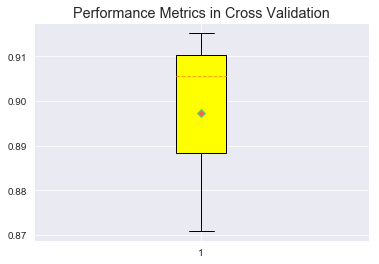



Model performance on train dataset


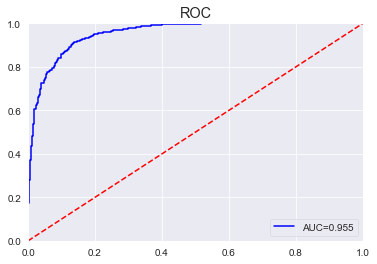

              precision    recall  f1-score   support

           0       0.93      0.81      0.86       607
           1       0.85      0.95      0.90       716

    accuracy                           0.88      1323
   macro avg       0.89      0.88      0.88      1323
weighted avg       0.89      0.88      0.88      1323



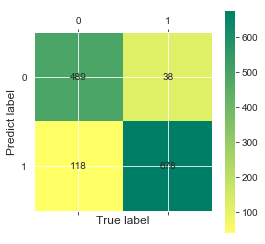



Model performance by decile on train dataset
    Model Obsverations Num  Model Book Num  non_booked  cumulative booked  \
1                      133             132           1              132.0   
2                      132             129           3              261.0   
3                      132             126           6              387.0   
4                      132             118          14              505.0   
5                      132              98          34              603.0   
6                      133              74          59              677.0   
7                      132              31         101              708.0   
8                      132               8         124              716.0   
9                      132               0         132              716.0   
10                     133               0         133              716.0   

    cumulative non_booked  %cum booked  %cum non_booked      diff  \
1                     1.0     0.1843

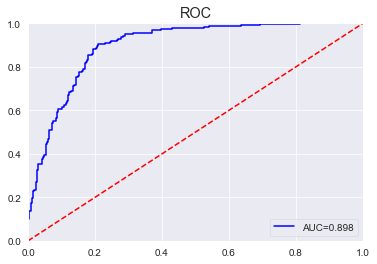

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       267
           1       0.83      0.87      0.85       300

    accuracy                           0.84       567
   macro avg       0.84      0.84      0.84       567
weighted avg       0.84      0.84      0.84       567



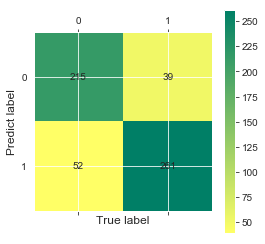



Model performance by decile on test dataset
    Model Obsverations Num  Model Book Num  non_booked  cumulative booked  \
1                       57              54           3               54.0   
2                       57              52           5              106.0   
3                       56              47           9              153.0   
4                       57              42          15              195.0   
5                       56              43          13              238.0   
6                       57              36          21              274.0   
7                       57              17          40              291.0   
8                       56               5          51              296.0   
9                       57               3          54              299.0   
10                      57               1          56              300.0   

    cumulative non_booked  %cum booked  %cum non_booked      diff  \
1                     3.0     0.18000

In [91]:
RF_Classifier_GridSearch(train_X, test_X, train_Y, test_Y, KFold = 3)

#### Load the booking probability model 

In [92]:
file = open('Book_Prob_Model_RF_GridSearch.pkl', 'rb')
book_prob_model = pk.load(file)
file.close()

In [93]:
book_prob_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=78132,
                       verbose=0, warm_start=False)

#### Feature Importance - Random Forest Model 

In [94]:
feature_importance = pd.DataFrame({'features': list(train_X.columns),
                                  'importance': book_prob_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending = False).reset_index(drop = True)
feature_importance

,features,importance
0,booked_rate_past28days,0.356986
1,days_past_since_last_booked,0.241545
2,demand_supply_ratio,0.135399
3,most_recent_nobooked_price,0.069868
4,most_recent_booked_price,0.066487
5,average_list_price_past28days,0.050651
6,tmv,0.047623
7,day_of_month,0.031441


#### Feature Importance - Permutation Importance

In [95]:
perm = PermutationImportance(book_prob_model, random_state = random_seed).fit(test_X, test_Y)
eli5.show_weights(perm, feature_names = test_X.columns.tolist())

Weight,Feature
0.0998 ± 0.0359,booked_rate_past28days
0.0631 ± 0.0106,days_past_since_last_booked
0.0451 ± 0.0154,demand_supply_ratio
0.0067 ± 0.0079,average_list_price_past28days
0.0039 ± 0.0068,most_recent_nobooked_price
-0.0000 ± 0.0109,tmv
-0.0025 ± 0.0065,day_of_month
-0.0025 ± 0.0057,most_recent_booked_price


#### Next step
* day_of_month and most_recent_booked_price have negative values for permutation importances on test dataset 
* which means these two feature didn't matter, decide to remove these two features and re-model

## Re-model without 'day_of_month' and 'most_recent_booked'

In [96]:
feature_selected_2 = ['booked_rate_past28days',
  'demand_supply_ratio',
  'days_past_since_last_booked',
  'tmv',
  'most_recent_nobooked_price',
  'average_list_price_past28days']

In [97]:
train_X_2 = dataframe2.loc[dataframe2['select'] == 'Development', feature_selected_2]
train_Y_2 = dataframe2.loc[dataframe2['select'] == 'Development', 'is_booked']
test_X_2 = dataframe2.loc[dataframe2['select'] == 'Test', feature_selected_2]
test_Y_2 = dataframe2.loc[dataframe2['select'] == 'Test', 'is_booked']

In [98]:
def RF_Classifier_GridSearch2(train_X, test_X, train_Y, test_Y, KFold = 3, random_state = random_seed):    
    
    # Hyperparameter tuning using GridSearchCV()
    model = RandomForestClassifier(random_state = random_state)
    parameters = {'max_depth'     : [6,8,10],
                  'criterion'     : ['gini', 'entropy'],
                  'max_features'  : ['auto', 'sqrt', 'log2'],
                  'n_estimators'  : [100,500,1000]
                 }
    grid = GridSearchCV(estimator=model, param_grid = parameters,
                        cv = KFold, verbose = 0, n_jobs = 4)
    grid.fit(train_X, train_Y)

    # Results from Grid Search
    print("\n========================================================")
    print(" Results from Grid Search " )
    print("========================================================")    
    print("\n The best estimator across ALL searched params:\n",
          grid.best_estimator_)
    print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)
    print("\n ========================================================")

    # Model build using best estimator from grid search
    model = grid.best_estimator_

    # Cross Validation
    ME.cross_verify(train_X, train_Y, model, fold = KFold)
    
    # Train the Model
    trained_model = model.fit(train_X, train_Y)
    
    # Model performance on train dataset
    print("\n\nModel performance on train dataset")   
    train_pred_prob = trained_model.predict_proba(train_X)[:, 1]
    train_pred_class = trained_model.predict(train_X)
    ME.plot_roc(train_Y, train_pred_prob)
    ME.plot_matrix_report(train_Y, train_pred_class)
    train_temp, train_performance, train_roc_plot = ME.KS_Lift(train_pred_prob, train_Y, redecile = False)
    print("\n\nModel performance by decile on train dataset") 
    print(train_temp)
    print(train_performance)
    
    # Model performance on test dataset
    print("\n\nModel performance on test dataset")   
    test_pred_prob = trained_model.predict_proba(test_X)[:, 1]
    test_pred_class = trained_model.predict(test_X)
    ME.plot_roc(test_Y, test_pred_prob)
    ME.plot_matrix_report(test_Y, test_pred_class)
    test_temp, test_performance, test_roc_plot = ME.KS_Lift(test_pred_prob, test_Y, redecile = False)
    print("\n\nModel performance by decile on test dataset") 
    print(test_temp)
    print(test_performance)
       
    # Save the trained Model
    with open('Book_Prob_Model_RF_GridSearch2' +'.pkl', 'wb') as file:
        pk.dump(trained_model, file)
    print("\n\nTrained models are saved on DISK... ... Done ...")       


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=78132,
                       verbose=0, warm_start=False)

 The best score across ALL searched params:
 0.8352229780801209

 The best parameters across ALL searched params:
 {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 500}

The max AUC in CV is:0.9146816355275694
The min AUC in CV is:0.8750953274110105
The average AUC in CV is:0.8987181217949023


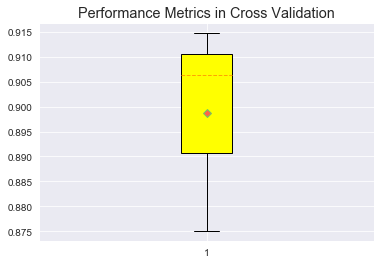



Model performance on train dataset


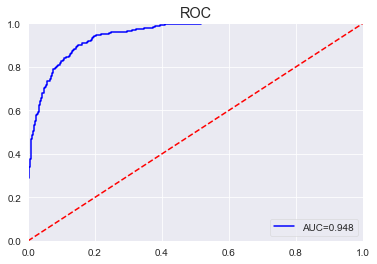

              precision    recall  f1-score   support

           0       0.92      0.80      0.86       607
           1       0.85      0.94      0.89       716

    accuracy                           0.88      1323
   macro avg       0.89      0.87      0.88      1323
weighted avg       0.88      0.88      0.88      1323



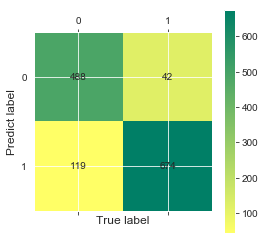



Model performance by decile on train dataset
    Model Obsverations Num  Model Book Num  non_booked  cumulative booked  \
1                      133             133           0              133.0   
2                      132             128           4              261.0   
3                      132             123           9              384.0   
4                      132             116          16              500.0   
5                      132              95          37              595.0   
6                      133              79          54              674.0   
7                      132              28         104              702.0   
8                      132              14         118              716.0   
9                      132               0         132              716.0   
10                     133               0         133              716.0   

    cumulative non_booked  %cum booked  %cum non_booked      diff  \
1                     0.0     0.1857

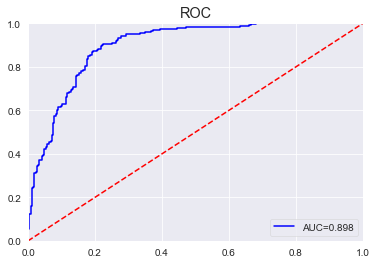

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       267
           1       0.83      0.88      0.85       300

    accuracy                           0.84       567
   macro avg       0.84      0.84      0.84       567
weighted avg       0.84      0.84      0.84       567



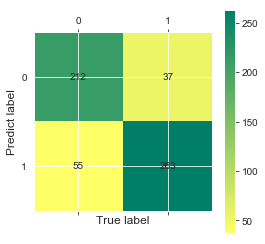



Model performance by decile on test dataset
    Model Obsverations Num  Model Book Num  non_booked  cumulative booked  \
1                       57              54           3               54.0   
2                       57              51           6              105.0   
3                       56              45          11              150.0   
4                       57              47          10              197.0   
5                       56              41          15              238.0   
6                       57              35          22              273.0   
7                       57              19          38              292.0   
8                       56               3          53              295.0   
9                       57               5          52              300.0   
10                      57               0          57              300.0   

    cumulative non_booked  %cum booked  %cum non_booked      diff  \
1                     3.0     0.18000

In [99]:
RF_Classifier_GridSearch2(train_X_2, test_X_2, train_Y_2, test_Y_2, KFold = 3)

#### Load the booking probability model2

In [100]:
file = open('Book_Prob_Model_RF_GridSearch2.pkl', 'rb')
book_prob_model2 = pk.load(file)
file.close()

#### Feature Importance - Random Forest Model 

In [102]:
feature_importance2 = pd.DataFrame({'features': list(train_X_2.columns),
                                  'importance': book_prob_model2.feature_importances_})
feature_importance2 = feature_importance2.sort_values('importance', ascending = False).reset_index(drop = True)
feature_importance2

,features,importance
0,booked_rate_past28days,0.331118
1,days_past_since_last_booked,0.257045
2,demand_supply_ratio,0.164621
3,most_recent_nobooked_price,0.095971
4,average_list_price_past28days,0.082755
5,tmv,0.068489


#### Feature Importance - Permutation Importance

In [103]:
perm2 = PermutationImportance(book_prob_model2, random_state = random_seed).fit(test_X_2, test_Y_2)
eli5.show_weights(perm2, feature_names = test_X_2.columns.tolist())

Weight,Feature
0.0871 ± 0.0345,booked_rate_past28days
0.0723 ± 0.0206,days_past_since_last_booked
0.0473 ± 0.0145,demand_supply_ratio
0.0078 ± 0.0069,most_recent_nobooked_price
0.0074 ± 0.0155,tmv
0.0063 ± 0.0028,average_list_price_past28days


## Model Selection Conclusion
* Choose the Book_Prob_Model_RF_GridSearch2.pkl as final booking probability model to predict the likelihood of vehicle being booked

* The model variables (5 variables) in the final variables (order by the importance) are:
    * booked_rate_past28days
    * days_past_since_last_booked	
    * demand_supply_ratio	
	* most_recent_nobooked_price	
    * average_list_price_past28days	
    * tmv

## Mode Performance Summary
| Metrics                                 | Model Train Dataset | Model Test Dataset |
|-----------------------------------------|---------------------|--------------------|
| Accuracy                                | 88%                 | 84%                |
| KS                                      | 0.74                | 0.66               |
| AUC                                     | 0.95                | 0.9                |
| Lift (Top 1 Decile)                     | 1.85                | 1.79               |
| % of Cumulative Booked in Top 3 Deciles | 0.54                | 0.5                |

### Univarate Analysis for each feature

In [135]:
def barchart(data, feat, target, n = 10):
    df = data.copy()
    rank, bins = pd.qcut(df[feat], q = n, retbins = True, duplicates = 'drop')
    decile, ind = pd.factorize(rank, sort = True)
    df['decile'] = decile
    ind2 = pd.DataFrame({'decile': np.arange(0, len(ind)), feat + '_range':ind}) 
    df = df.merge(ind2, on = 'decile')
    df['decile'] = df['decile'] + 1 
    vis = df.groupby(['decile', feat + '_range'])[target].agg(['count', 'sum']).reset_index().rename(columns = {'count': 'Number of Observations', 'sum':'Number of Booked'})                                                                         
    vis['Percentage of Obsverations'] = round((vis['Number of Observations'] / vis['Number of Observations'].sum()) * 100, 2)
    vis['Booked Rate(%)'] = round((vis['Number of Booked'] / vis['Number of Observations']) * 100, 2)    
    print('Relation Between ' + feat + ' with ' + target + ' Summary Table')
    print(vis)
    print("\n========================================================")
    print('Relation Between ' + feat + ' with ' + target + ' Summary Chart')
    ax = sns.barplot(x='decile', y='Number of Observations', data=vis, color="Pink")
    vis['Booked Rate(%)'].plot(kind='line', color = 'k', secondary_y=True)
    plt.ylabel('Booked Rate(%)')
    plt.yticks(np.arange(1, 10) * 10)
    sns.despine(left=True)

Relation Between booked_rate_past28days with is_booked Summary Table
   decile booked_rate_past28days_range  Number of Observations  \
0       1              (-0.001, 0.167]                     574   
1       2               (0.167, 0.429]                     189   
2       3                 (0.429, 0.6]                     187   
3       4                  (0.6, 0.75]                     206   
4       5                (0.75, 0.857]                     193   
5       6                 (0.857, 1.0]                     541   

   Number of Booked  Percentage of Obsverations  Booked Rate(%)  
0                64                       30.37           11.15  
1                88                       10.00           46.56  
2               103                        9.89           55.08  
3               136                       10.90           66.02  
4               145                       10.21           75.13  
5               480                       28.62           88.72  

Relat

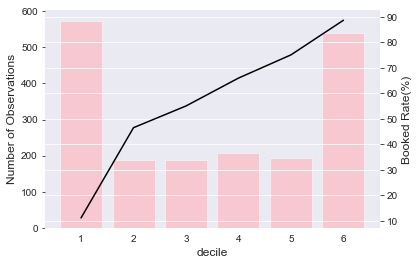

In [136]:
barchart(dataframe2, 'booked_rate_past28days', 'is_booked', n = 10)

* booked_rate_past28days has positive relationship with is_booked - as expected from business sense
* higher booked_rate_past28days will have higher likelihood for vehicle being booked

Relation Between days_past_since_last_booked with is_booked Summary Table
   decile days_past_since_last_booked_range  Number of Observations  \
0       1                     (-0.001, 1.0]                     477   
1       2                        (1.0, 2.0]                     210   
2       3                        (2.0, 3.0]                     159   
3       4                        (3.0, 4.0]                     116   
4       5                        (4.0, 6.0]                     178   
5       6                       (6.0, 10.0]                     187   
6       7                      (10.0, 20.0]                     186   
7       8                      (20.0, 66.1]                     188   
8       9                     (66.1, 362.0]                     189   

   Number of Booked  Percentage of Obsverations  Booked Rate(%)  
0               301                       25.24           63.10  
1               177                       11.11           84.29  
2               1

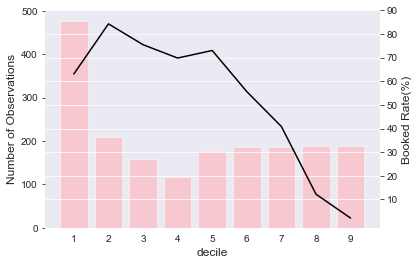

In [137]:
barchart(dataframe2, 'days_past_since_last_booked', 'is_booked', n = 10)

* days_past_since_last_booked has negative relationship with is_booked - as expected from business sense
* less days_past_since_last_booked will have higher likelihood for vehicle being booked
* If this vehicle just booked recently, this vehicle have higher likelihood will booked

Relation Between demand_supply_ratio with is_booked Summary Table
   decile demand_supply_ratio_range  Number of Observations  Number of Booked  \
0       1            (0.462, 0.985]                     191                51   
1       2            (0.985, 1.515]                     187                62   
2       3            (1.515, 4.013]                     189                79   
3       4            (4.013, 5.024]                     189                83   
4       5            (5.024, 5.694]                     189                86   
5       6            (5.694, 6.688]                     189               101   
6       7            (6.688, 7.876]                     189               110   
7       8            (7.876, 9.042]                     189               135   
8       9           (9.042, 11.144]                     189               141   
9      10          (11.144, 23.333]                     189               168   

   Percentage of Obsverations  Booked Rate

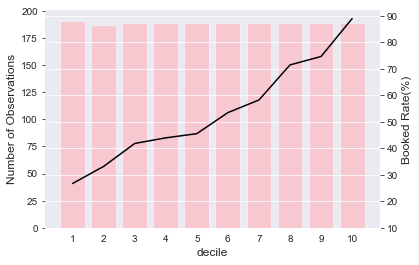

In [138]:
barchart(dataframe2, 'demand_supply_ratio', 'is_booked', n = 10)

* days_past_since_last_booked has negative relationship with is_booked - as expected from business sense
* less days_past_since_last_booked will have higher likelihood for vehicle being booked
* If this vehicle just booked recently, this vehicle have higher likelihood will booked

Relation Between most_recent_nobooked_price with is_booked Summary Table
   decile most_recent_nobooked_price_range  Number of Observations  \
0       1                   (-0.001, 25.0]                     388   
1       2                     (25.0, 30.0]                     243   
2       3                     (30.0, 34.6]                     125   
3       4                     (34.6, 38.0]                     248   
4       5                     (38.0, 40.0]                     219   
5       6                     (40.0, 45.0]                     111   
6       7                     (45.0, 55.0]                     221   
7       8                     (55.0, 81.0]                     147   
8       9                    (81.0, 125.0]                     188   

   Number of Booked  Percentage of Obsverations  Booked Rate(%)  
0               312                       20.53           80.41  
1               152                       12.86           62.55  
2                69         

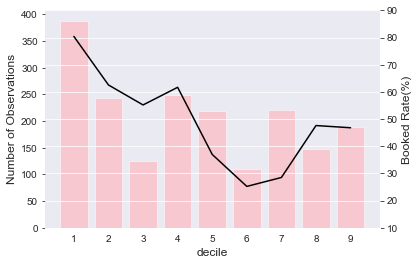

In [139]:
barchart(dataframe2, 'most_recent_nobooked_price', 'is_booked', n = 10)

* most_recent_nobooked_price has mixed relationship with is_booked 
* lower non-booked price recently has higher likelihood for vehicle being booked until non-booked price below \$45
* From non-booked price above \$45, higher non-booked price recently has higher likelihood for vehicle being booked

Relation Between average_list_price_past28days with is_booked Summary Table
   decile average_list_price_past28days_range  Number of Observations  \
0       1                    (-0.001, 25.663]                     189   
1       2                      (25.663, 29.0]                     226   
2       3                        (29.0, 31.6]                     153   
3       4                        (31.6, 34.0]                     199   
4       5                        (34.0, 39.0]                     228   
5       6                        (39.0, 40.0]                     184   
6       7                      (40.0, 45.038]                     144   
7       8                     (45.038, 57.21]                     189   
8       9                      (57.21, 82.25]                     190   
9      10                    (82.25, 119.333]                     188   

   Number of Booked  Percentage of Obsverations  Booked Rate(%)  
0               125                       10.00       

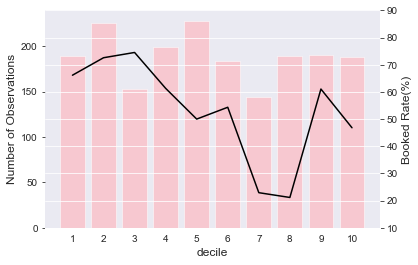

In [140]:
barchart(dataframe2, 'average_list_price_past28days', 'is_booked', n = 10)

* average_list_price_past28days has mixed relationship with is_booked 
* lower average_list_price_past28days has higher likelihood for vehicle being booked until the price below \$57
* From average_list_price_past28days above \$57, higher average_list_price_past28days has higher likelihood for vehicle being booked

Relation Between tmv with is_booked Summary Table
   decile           tmv_range  Number of Observations  Number of Booked  \
0       1  (3874.999, 5669.0]                     204               126   
1       2    (5669.0, 6353.0]                     231               172   
2       3    (6353.0, 7484.0]                     198               107   
3       4    (7484.0, 8941.0]                     214               114   
4       5   (8941.0, 10850.0]                     111                20   
5       6  (10850.0, 14569.0]                     250                40   
6       7  (14569.0, 18150.0]                     183               106   
7       8  (18150.0, 19525.0]                     196               167   
8       9  (19525.0, 26808.0]                     120                82   
9      10  (26808.0, 39102.0]                     183                82   

   Percentage of Obsverations  Booked Rate(%)  
0                       10.79           61.76  
1                       12.2

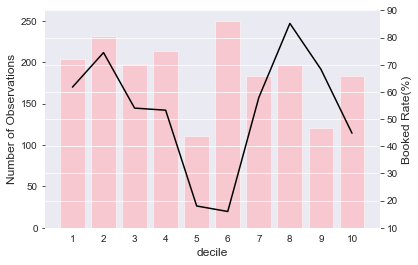

In [149]:
barchart(dataframe2, 'tmv', 'is_booked', n = 10)

* Lower and higher true market value of vehicle have higher booked rate
* Middle or just average true market value of vehicle have really lower booked rate

## Next Step

### Score the whole dataframe2 dataset, add a column 'probability_booked' in dataframe2 dataset as input for pricing regression model using Book_Prob_Model_RF_GridSearch2.pkl

In [143]:
final_feature_list_booking_prob_model = ['booked_rate_past28days',
  'demand_supply_ratio',
  'days_past_since_last_booked',
  'tmv',
  'most_recent_nobooked_price',
  'average_list_price_past28days']

In [144]:
dataframe2['probability_booked'] = book_prob_model2.predict_proba(dataframe2[final_feature_list_booking_prob_model])[:, 1]

In [146]:
dataframe2.head()

,vehicle_id,date,tmv,category_grouped,demand_supply_ratio,price,year_month,day_of_month,day_of_week,weekend,holiday,category_grouped_num,most_recent_booked_price,most_recent_nobooked_price,days_past_since_last_booked,booked_rate_past28days,average_list_price_past28days,is_booked,select,probability_booked
494,497131,2018-11-30,3875,compact,8.348333,25,2018-11,30,5,0,0,0,25.0,30.0,16.0,1.000000,25.0,1,Development,0.880484
1195,174075,2018-08-26,5669,midsize,12.210682,46,2018-08,26,7,1,0,1,39.0,34.0,3.0,1.000000,39.0,1,Development,0.905367
1379,289235,2018-07-06,17755,midsize,1.959080,55,2018-07,6,5,0,0,1,55.0,55.0,12.0,0.285714,55.0,1,Development,0.296225
973,456223,2019-02-06,9666,midsize,0.741782,52,2019-02,6,3,0,0,1,42.0,52.0,175.0,0.000000,52.0,0,Development,0.007452
1738,300476,2018-04-09,6353,suv,5.295696,27,2018-04,9,1,0,0,2,27.0,29.0,12.0,1.000000,28.0,0,Development,0.719957


#### Save the dataframe2 dataset for pricing regression model input dataset

In [147]:
dataframe2.to_csv('dataframe_price_booking_probability.csv', index=False)

#### Calculate Information Value

In [ ]:
dataframe_woe = dataframe[['tmv',
'demand_supply_ratio',
'day_of_month',
'day_of_week',
'weekend',
'holiday',
'category_grouped_num',
'most_recent_booked_price',
'most_recent_nobooked_price',
'days_past_since_last_booked',
'booked_rate_past28days',
'average_list_price_past28days',
'is_booked']]

In [ ]:
dataframe_IV = woe.WOE(dataframe_woe,'is_booked',bins=10,category_max=10)

In [ ]:
dataframe_IV.fit()

In [ ]:
dataframe_IV.woe_continuous('tmv',chart=True)

In [ ]:
dataframe_IV.woe_continuous('demand_supply_ratio',chart=True)

In [ ]:
dataframe_IV.woe_continuous('day_of_month',chart=True)

In [ ]:
dataframe_IV.woe_continuous('day_of_week',chart=True)

In [ ]:
dataframe_IV.woe_continuous('weekend',chart=True)

In [ ]:
dataframe_IV.woe_continuous('holiday',chart=True)

In [ ]:
dataframe_IV.woe_continuous('category_grouped_num',chart=True)

In [ ]:
dataframe_IV.woe_continuous('most_recent_booked_price',chart=True)

In [ ]:
dataframe_IV.woe_continuous('most_recent_nobooked_price',chart=True)

In [ ]:
dataframe_IV.woe_continuous('days_past_since_last_booked',chart=True)

In [ ]:
dataframe_IV.woe_continuous('booked_rate_past28days',chart=True)

In [ ]:
dataframe_IV.woe_continuous('average_list_price_past28days',chart=True)

In [ ]:
dataframe_IV.export('dataframe_IV.xlsx')